In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function
import math

In [147]:
exponential_count =2
parameter_count = exponential_count*2+1

Load a model or creat a new one?

In [148]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [149]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\crpdn\AppData\Local\Temp\ipykernel_8484\431649043.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [150]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:50*10])
df.head()

,Pattern,Time,Current,On time,Off time
500,11/1000,79.005742,1.564,74,155
501,11/1000,79.230081,1.422,74,155
502,11/1000,79.460954,1.329,74,155
503,11/1000,79.690012,1.261,74,155
504,11/1000,79.921769,1.212,74,155


In [151]:
target_points = 50
cutoff_current_min = 0
must_be_growth = False
must_be_decay = False
min_gradient =0
max_final_gradient = 1

In [152]:
# grouped = df.groupby('Pattern')
# list_of_dfs = [group for _, group in grouped]
# list_of_dfs_fixed = []
# for data in list_of_dfs:    
#     x_time = data['Time']-np.min(data['Time'])
#     y_current = data['Current']
#     points = len(y_current)    
#     #(data.loc[0,'Off time'])
#     if len(y_current) != target_points:
#         print(points)
#         continue
#     assert x_time.shape == y_current.shape
#     assert points == target_points
#     if np.min(y_current)>cutoff_current_min and np.max(np.abs(np.gradient(y_current,y_current.index)))>min_gradient and np.min(np.abs(np.gradient(y_current,y_current.index)[:-10]))<max_final_gradient:
#         if must_be_growth:
#             if y_current.iloc[0]<y_current.iloc[-1]:
#                 plt.plot(x_time, y_current, '-')
#                 list_of_dfs_fixed.append(data)
#         elif   must_be_decay:
#             if y_current.iloc[0]>y_current.iloc[-1]:
#                 plt.plot(x_time, y_current, '-')
#                 list_of_dfs_fixed.append(data)          
#         else:
#             plt.plot(x_time, y_current, '-')
#             list_of_dfs_fixed.append(data)
# plt.xlabel('Time')
# plt.ylabel('Current')
# plt.title('Data to be modeled')

In [153]:
#initialize array of expected shape
X_data = np.zeros((len(df)-1,3))
#initialize array of expected shape
y_data = np.zeros((len(df)-1,1))

X_data[:,0] = df['Current'][:-1]
X_data[:,1] = df['On time'][1:]
X_data[:,2] = df['Off time'][1:]
y_data[:,0] = df['Current'][1:]
print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")


X shape:(49499, 3)
y shape:(49499, 1)


In [154]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)


In [155]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# y_train = scaler.fit_transform(y_train)
# y_val = scaler.transform(y_val)
# y_test = scaler.transform(y_test)



In [156]:
print("Information about x_train values:")
print("Minimum value:", np.min(X_train))
print("Maximum value:", np.max(X_train))
print("Mean value:", np.mean(X_train))
print("Standard deviation:", np.std(X_train))

Information about x_train values:
Minimum value: 0.04399
Maximum value: 160.0
Mean value: 49.86831724994469
Standard deviation: 45.94908722686769


In [267]:
import keras

import tensorflow.keras.backend as K



def create_nn(dropout_rate=0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 4
    number_of_layers = 2
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'linear')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(y_train.shape[1], activation = 'linear')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="current_function_prediction")

In [268]:
if load:
    model = keras.models.load_model(model_path, custom_objects={'custom_loss':custom_loss})
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_91 (Dense)            (None, 4)                 16        
                                                                 
 dense_92 (Dense)            (None, 4)                 20        
                                                                 
 dense_93 (Dense)            (None, 1)                 5         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [269]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='mse'
                  )
    


number_of_epochs = 100




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [270]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/100


1083/1083 - 2s - loss: 28.3711 - val_loss: 0.0528 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 2/100
1083/1083 - 1s - loss: 0.0286 - val_loss: 0.0102 - lr: 0.0010 - 964ms/epoch - 890us/step
Epoch 3/100
1083/1083 - 1s - loss: 0.0045 - val_loss: 0.0015 - lr: 0.0010 - 977ms/epoch - 902us/step
Epoch 4/100
1083/1083 - 1s - loss: 7.9694e-04 - val_loss: 3.8613e-04 - lr: 0.0010 - 970ms/epoch - 896us/step
Epoch 5/100
1083/1083 - 1s - loss: 2.8129e-04 - val_loss: 2.1480e-04 - lr: 0.0010 - 1s/epoch - 939us/step
Epoch 6/100
1083/1083 - 1s - loss: 2.3735e-04 - val_loss: 2.1883e-04 - lr: 0.0010 - 998ms/epoch - 922us/step
Epoch 7/100
1083/1083 - 1s - loss: 2.9432e-04 - val_loss: 3.0631e-04 - lr: 0.0010 - 962ms/epoch - 888us/step
Epoch 8/100
1083/1083 - 1s - loss: 4.1050e-04 - val_loss: 2.2261e-04 - lr: 0.0010 - 966ms/epoch - 892us/step
Epoch 9/100
1083/1083 - 1s - loss: 6.7116e-04 - val_loss: 8.9488e-04 - lr: 0.0010 - 1s/epoch - 962us/step
Epoch 10/100
1083/1083 - 1s - loss: 8.3252e-04 - val_loss: 2.2858

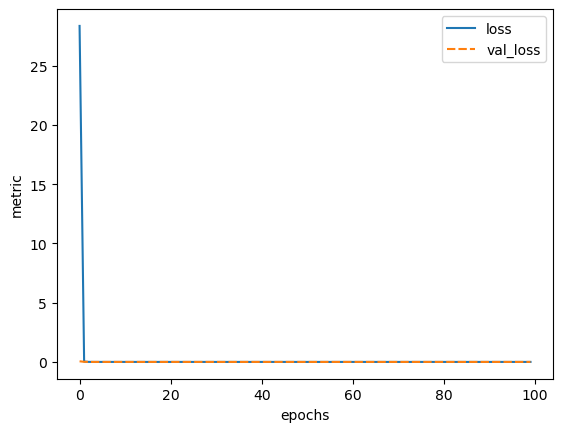

In [271]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss', 'val_loss'], 0)

In [272]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

In [273]:
# make prediction on test data
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

233/233 [==============================] - 0s 711us/step


Text(0.5, 1.0, 'True vs predicted next step current (test data)')

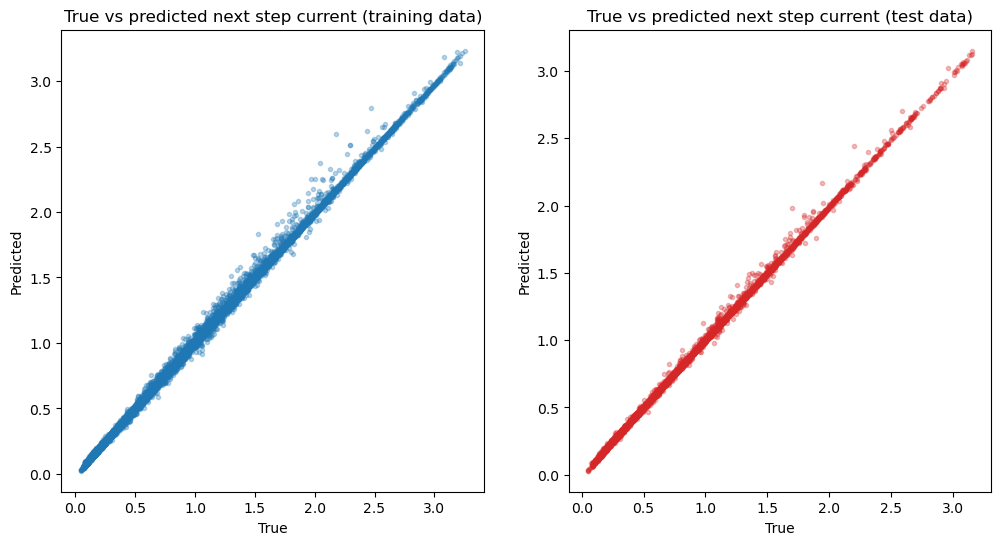

In [274]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(y_train, y_train_prediction, '.', color = 'C0', alpha = 0.3, )
# plt.legend()
    # plt.ylim(-1,1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs predicted next step current (training data)')





plt.subplot(1, 2, 2)

plt.plot(y_test,y_test_prediction, '.', color = 'C3', alpha = 0.3, )
    
#plt.legend()
# plt.ylim(-1,1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs predicted next step current (test data)')
# plt.savefig(f"{folder_path}/performance.png")

Text(0.5, 1.0, 'Accuracy of next step current prediction (test data)')

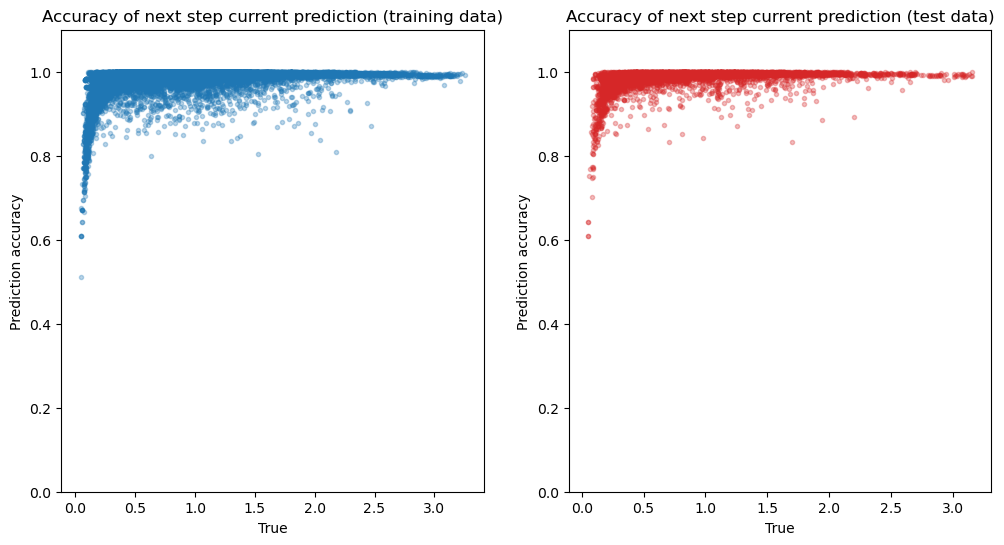

In [277]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(y_train, 1-np.abs(y_train_prediction-y_train)/y_train, '.', color = 'C0', alpha = 0.3, )
# plt.legend()
plt.ylim(0,1.1)
plt.xlabel('True')
plt.ylabel('Prediction accuracy')
plt.title('Accuracy of next step current prediction (training data)')





plt.subplot(1, 2, 2)

plt.plot(y_test,1-np.abs(y_test_prediction-y_test)/y_test, '.', color = 'C3', alpha = 0.3, )
    
#plt.legend()
plt.ylim(0,1.1)
plt.xlabel('True')
plt.ylabel('Prediction accuracy')
plt.title('Accuracy of next step current prediction (test data)')
# plt.savefig(f"{folder_path}/performance.png")